# Pooled, Unpooled and Hierarchial Regression using the Iris dataset

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr
print(f"Running on PyMC v{pm.__version__}")

df = pd.read_csv(r'../../Downloads/iris.csv')
df

Running on PyMC v3.11.2


,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [94]:
df.corr()

# we will do petal_width ~ petal_length

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

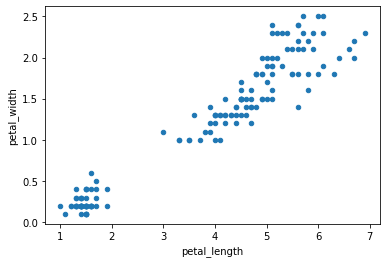

In [95]:
df.plot(kind='scatter', x='petal_length', y='petal_width')

In [5]:
class_id, classes = pd.factorize(df['class'])
coords = {
    "classes": classes,
    "observation": np.arange(df.shape[0]),
}

# Pooled model

In [18]:
with pm.Model(coords=coords) as pooled_model:
    pl = pm.Data('petal_length', df.petal_length)
    
    y = pm.Data('y',df.petal_width)
    
    a = pm.Normal("Intercept", 0, sigma=5)
    b = pm.Normal("beta", 0, sigma=5)

    sigma = pm.HalfNormal('sigma', sd=1)
    
    mu = pm.Deterministic('mu', a+b*pl, dims='observation')
    
    #est = a+b*pl
    yhat = pm.Normal('yhat', mu=mu, sd=sigma, observed=y, dims="observation")
    
    pooled_trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, model=pooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, Intercept]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 31 seconds.


0, dim: observation, 150 =? 150


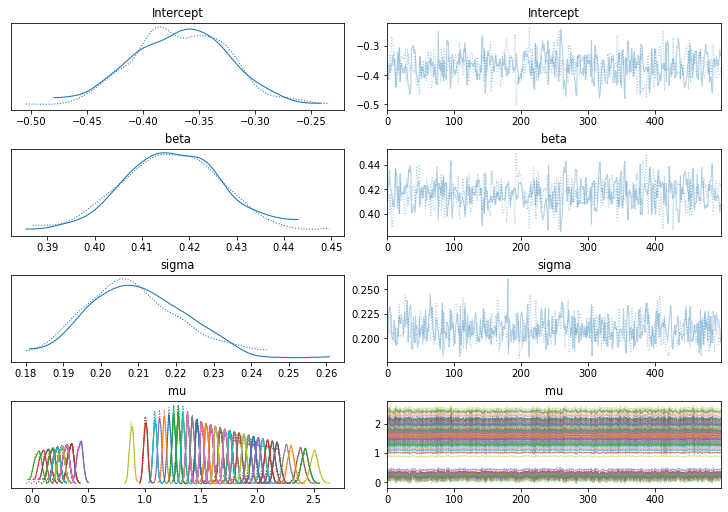

In [6]:
az.plot_trace(pooled_trace, figsize=(10, 7));

In [7]:
pm.summary(pooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.367,0.043,-0.449,-0.292,0.002,0.001,515.0,514.0,513.0,489.0,1.01
beta,0.416,0.011,0.398,0.438,0.000,0.000,541.0,541.0,539.0,523.0,1.01
sigma,0.209,0.013,0.188,0.234,0.001,0.000,547.0,547.0,535.0,429.0,1.00
mu[0],0.216,0.030,0.162,0.273,0.001,0.001,536.0,534.0,531.0,548.0,1.00
mu[1],0.216,0.030,0.162,0.273,0.001,0.001,536.0,534.0,531.0,548.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
mu[145],1.799,0.023,1.758,1.843,0.001,0.001,888.0,888.0,889.0,760.0,1.01
mu[146],1.716,0.021,1.677,1.757,0.001,0.000,934.0,934.0,934.0,878.0,1.00
mu[147],1.799,0.023,1.758,1.843,0.001,0.001,888.0,888.0,889.0,760.0,1.01
mu[148],1.882,0.024,1.836,1.927,0.001,0.001,849.0,849.0,849.0,695.0,1.01


In [8]:
with pooled_model:
    pp_y = pm.sample_posterior_predictive(pooled_trace, keep_size=True)["yhat"]

[Text(0.5, 15.0, 'slope'),
 Text(602.0470588235295, 0.5, 'intercept'),
 Text(0.5, 1.0, 'Parameter space')]

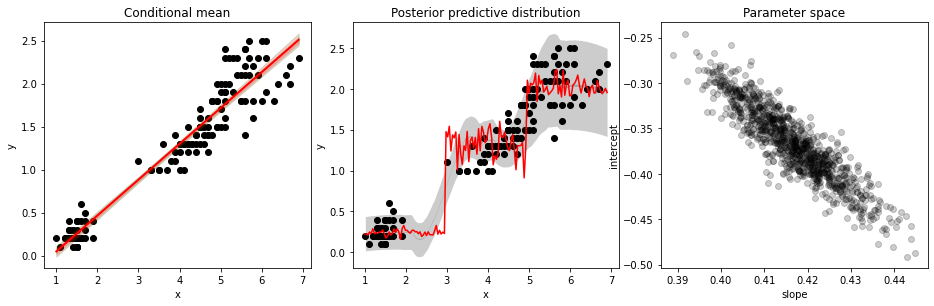

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
fig.tight_layout()
ax[0].scatter(df.petal_length, df.petal_width, color="k")

post = pooled_trace.posterior.stack(sample=("chain", "draw"))
xi = xr.DataArray(np.linspace(np.min(df.petal_length), np.max(df.petal_length), 150), dims=["x_plot"])
y = post.Intercept + post.beta * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
ax[0].fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="r", edgecolor="g"
)
ax[0].fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="r", edgecolor="g"
)
# conditional mean
ax[0].plot(xi, region.sel(quantile=0.5), "r", linewidth=2)
# formatting
ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

ax[1].scatter(df.petal_length, df.petal_width, color="k")
# posterior mean and HDI's
ax[1].plot(xi, np.mean(pp_y, axis=(0, 1)), "r")
az.plot_hdi(
    xi,
    pp_y,
    hdi_prob=0.05,
    color="k",
    fill_kwargs={"alpha": 0.2, "linewidth": 0},
    ax=ax[1],
)
az.plot_hdi(
    xi,
    pp_y,
    hdi_prob=0.95,
    color="k",
    fill_kwargs={"alpha": 0.2, "linewidth": 0},
    ax=ax[1],
)

ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")


ax[2].scatter(
    pooled_trace.posterior.beta.stack(sample=("chain", "draw")),
    pooled_trace.posterior.Intercept.stack(sample=("chain", "draw")),
    color="k",
    alpha=0.2,
)


ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")

# Unpooled model

In [44]:
with pm.Model(coords=coords) as unpooled_model:
    pl = pm.Data('petal_length', df.petal_length, dims='observation')
    flower = pm.Data("flower", class_id, dims="observation")
    y = pm.Data('y',df.petal_width)
    
    a = pm.Normal("Intercept", 0, sigma=5, dims='classes')
    b = pm.Normal("beta", 0, sigma=5, dims='classes')

    sigma = pm.HalfNormal('sigma', sd=1, dims='classes')
    
    mu = pm.Deterministic('mu', a[flower]+b[flower]*pl, dims='observation')
    
    #est = a+b*pl
    yhat = pm.Normal('yhat', mu=mu, sd=sigma[flower], observed=y, dims="observation")
    
    unpooled_trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, model=unpooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, Intercept]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 44 seconds.


0, dim: observation, 150 =? 150


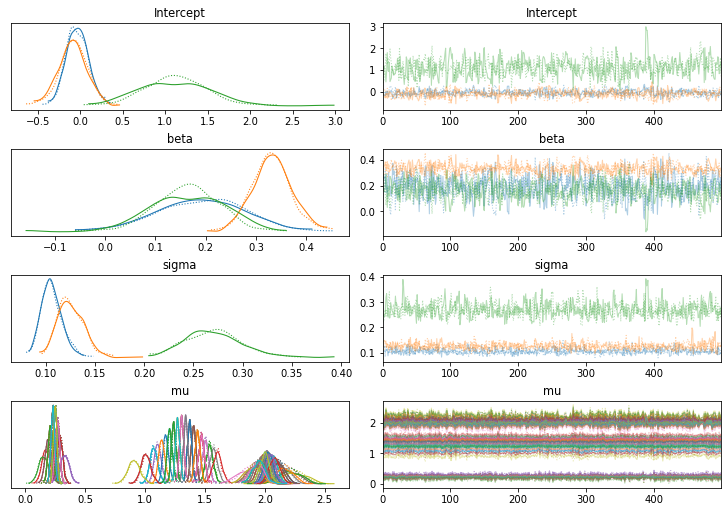

In [45]:
az.plot_trace(unpooled_trace, figsize=(10, 7));

In [46]:
pm.summary(unpooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],-0.036,0.129,-0.276,0.196,0.006,0.004,537.0,520.0,540.0,446.0,1.00
Intercept[1],-0.086,0.166,-0.393,0.228,0.007,0.005,612.0,475.0,611.0,591.0,1.00
Intercept[2],1.118,0.396,0.420,1.830,0.017,0.013,518.0,460.0,542.0,607.0,1.01
beta[0],0.191,0.087,0.024,0.348,0.004,0.003,532.0,532.0,534.0,469.0,1.00
beta[1],0.332,0.039,0.258,0.406,0.002,0.001,618.0,618.0,617.0,613.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
mu[145],1.968,0.047,1.881,2.060,0.002,0.001,865.0,863.0,865.0,743.0,1.00
mu[146],1.935,0.057,1.831,2.037,0.002,0.001,727.0,724.0,736.0,726.0,1.00
mu[147],1.968,0.047,1.881,2.060,0.002,0.001,865.0,863.0,865.0,743.0,1.00
mu[148],2.000,0.041,1.924,2.077,0.001,0.001,1032.0,1031.0,1030.0,855.0,1.00


In [61]:
xi = [np.linspace(df.loc[df['class'] == i].petal_length.min(), df.loc[df['class'] == i].petal_length.max(), 50) for i in classes]
g = [np.ones(50) * i for i, _ in enumerate(classes)]
xi, g = np.concatenate(xi), np.concatenate(g)
with unpooled_model:
    pp_y = pm.sample_posterior_predictive(unpooled_trace, keep_size=True)["yhat"]

[Text(0.5, 15.0, 'slope'),
 Text(602.0470588235295, 0.5, 'intercept'),
 Text(0.5, 1.0, 'Parameter space')]

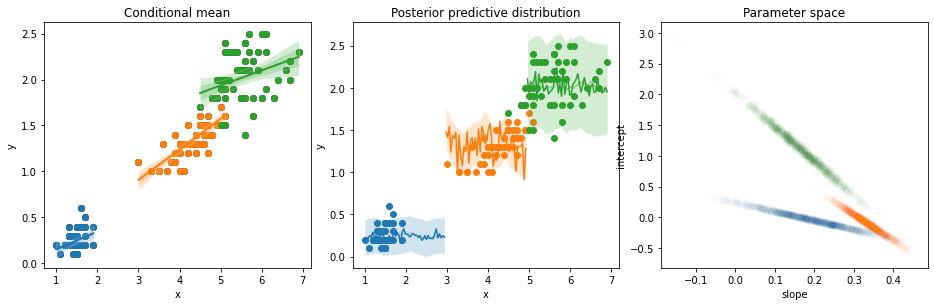

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
fig.tight_layout()
ax[0].scatter(df.petal_length, df.petal_width, color="k")

for i, groupname in enumerate(classes):
    ax[0].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    post = unpooled_trace.posterior.stack(sample=("chain", "draw"))
    _xi = xr.DataArray(
        np.linspace(df.loc[df['class'] == groupname].petal_length.min(), df.loc[df['class'] == groupname].petal_length.max(), 50),
        dims=["x_plot"]
    )
    y = post.Intercept.sel(classes=groupname) + post.beta.sel(classes=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")


for i, groupname in enumerate(classes):
    ax[1].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    ax[1].plot(xi[g == i], np.mean(pp_y[:, :, g == i], axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        pp_y[:, :, g == i],
        hdi_prob=0.05,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi[g == i],
        pp_y[:, :, g == i],
        hdi_prob=0.95,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

for i, _ in enumerate(classes):
    ax[2].scatter(
        unpooled_trace.posterior.beta.stack(sample=("chain", "draw"))[i, :],
        unpooled_trace.posterior.Intercept.stack(sample=("chain", "draw"))[i, :],
        color=f"C{i}",
        alpha=0.01,
        rasterized=True,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")

# Hierarchical Model

In [13]:
with pm.Model(coords=coords) as hierarchical_model:
    intercept_mu = pm.Normal('intercept_mu', 0, sigma=100)
    intercept_sigma = pm.HalfNormal('intercept_sigma', sd=5)
    slope_mu = pm.Normal('slope_mu', 0, sigma=100)
    slope_sigma = pm.HalfNormal('slope_sigma', sd=5)
    
    pl = pm.Data('petal_length', df.petal_length, dims='observation')
    flower = pm.Data('flower', class_id, dims='observation')
    y = pm.Data('y',df.petal_width)
    
    a = pm.Normal('Intercept', mu=intercept_mu, sigma=intercept_sigma, dims='classes')
    b = pm.Normal('beta', mu=slope_mu, sigma=slope_sigma, dims='classes')

    sigma = pm.HalfNormal('sigma', sd=5, dims='classes')
    
    mu = pm.Deterministic('mu', a[flower]+b[flower]*pl, dims='observation')
    
    #est = a+b*pl
    yhat = pm.Normal('yhat', mu=mu, sd=sigma[flower], observed=y, dims='observation')
    
    hierarchical_trace = pm.sample(tune=4000, draws=500, cores=2, target_accept=.99, return_inferencedata=True, model=hierarchical_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, Intercept, slope_sigma, slope_mu, intercept_sigma, intercept_mu]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 4_000 tune and 500 draw iterations (8_000 + 1_000 draws total) took 383 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: observation, 150 =? 150


array([[<AxesSubplot:title={'center':'intercept_mu'}>,
        <AxesSubplot:title={'center':'intercept_mu'}>],
       [<AxesSubplot:title={'center':'slope_mu'}>,
        <AxesSubplot:title={'center':'slope_mu'}>],
       [<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'intercept_sigma'}>,
        <AxesSubplot:title={'center':'intercept_sigma'}>],
       [<AxesSubplot:title={'center':'slope_sigma'}>,
        <AxesSubplot:title={'center':'slope_sigma'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

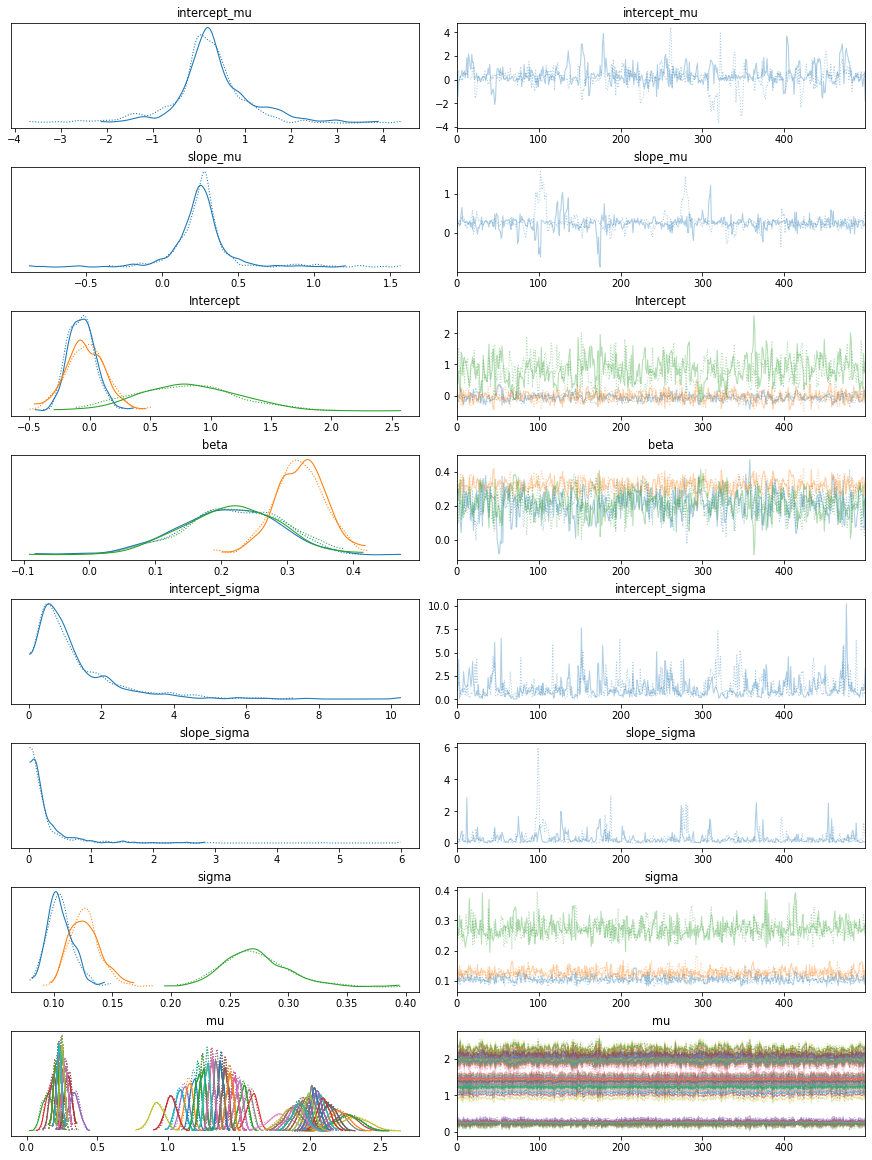

In [14]:
az.plot_trace(hierarchical_trace)

In [15]:
pm.summary(hierarchical_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept_mu,0.263,0.843,-1.450,1.862,0.053,0.037,254.0,254.0,313.0,185.0,1.01
slope_mu,0.262,0.200,-0.124,0.592,0.016,0.013,152.0,120.0,257.0,131.0,1.00
Intercept[0],-0.067,0.112,-0.274,0.142,0.006,0.004,396.0,329.0,407.0,491.0,1.00
Intercept[1],-0.032,0.163,-0.354,0.257,0.007,0.006,547.0,386.0,549.0,611.0,1.00
Intercept[2],0.815,0.412,0.067,1.575,0.024,0.017,300.0,300.0,293.0,350.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
mu[145],1.946,0.048,1.857,2.037,0.002,0.001,583.0,583.0,580.0,548.0,1.00
mu[146],1.902,0.058,1.792,2.009,0.003,0.002,457.0,457.0,453.0,502.0,1.00
mu[147],1.946,0.048,1.857,2.037,0.002,0.001,583.0,583.0,580.0,548.0,1.00
mu[148],1.989,0.041,1.906,2.059,0.001,0.001,769.0,769.0,762.0,576.0,1.00


In [16]:
xi = [np.linspace(df.loc[df['class'] == i].petal_length.min(), df.loc[df['class'] == i].petal_length.max(), 50) for i in classes]
g = [np.ones(50) * i for i, _ in enumerate(classes)]
xi, g = np.concatenate(xi), np.concatenate(g)
# Do the posterior prediction
with hierarchical_model:
    pp_y = pm.sample_posterior_predictive(hierarchical_trace, keep_size=True)["yhat"]

[Text(0.5, 15.0, 'slope'),
 Text(553.6588235294118, 0.5, 'intercept'),
 Text(0.5, 1.0, 'Parameter space')]

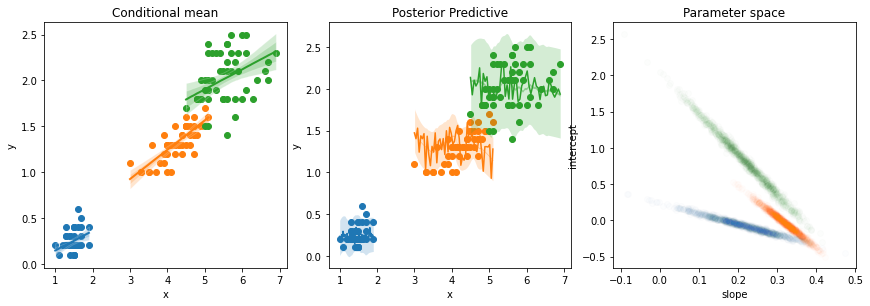

In [17]:
rng = np.random.default_rng(1234)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()
for i, groupname in enumerate(classes):
    ax[0].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    post = hierarchical_trace.posterior.stack(sample=("chain", "draw"))
    _xi = xr.DataArray(
        np.linspace(df.loc[df['class'] == groupname].petal_length.min(), df.loc[df['class'] == groupname].petal_length.max(), 50),
        dims=["x_plot"]
    )
    y = post.Intercept.sel(classes=groupname) + post.beta.sel(classes=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

for i, groupname in enumerate(classes):
    ax[1].scatter(df.loc[df['class'] == groupname].petal_length, df.loc[df['class'] == groupname].petal_width, color=f"C{i}")
    ax[1].plot(xi[g == i], np.mean(pp_y[:, :, g == i], axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        pp_y[:, :, g == i],
        hdi_prob=0.05,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi[g == i],
        pp_y[:, :, g == i],
        hdi_prob=0.95,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior Predictive")

for i, _ in enumerate(classes):
    ax[2].scatter(
        hierarchical_trace.posterior.beta.stack(sample=("chain", "draw"))[i, :],
        hierarchical_trace.posterior.Intercept.stack(sample=("chain", "draw"))[i, :],
        color=f"C{i}",
        alpha=0.01,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")